<a href="https://colab.research.google.com/github/sbarreto10/data-science-2022/blob/main/SPOTIFY%20DATASET%20(TP3)/75_06_TP_3_MODELOS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **LECTURA**

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
pd.options.mode.chained_assignment = None

In [ ]:
trainDf = pd.read_parquet("/content/drive/MyDrive/tp3/train.parquet")
testDf = pd.read_parquet("/content/drive/MyDrive/tp3/test.parquet")

# **SPLIT**

In [ ]:
random.seed(3)
artistList = trainDf.artist.unique().tolist()
validationArtists = random.sample(artistList, int(0.2*len(artistList)))
trainDf, valDf = trainDf.query("artist not in @validationArtists"), trainDf.query("artist in @validationArtists")

# **PREPROCESAMIENTO**

In [ ]:
genreList = trainDf["genre"].unique().tolist()

In [ ]:
import string
import nltk
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
stopwordsSpEn = set(stopwords.words('english')+stopwords.words('spanish'))
sPunctuations = list(string.punctuation)
sDigits = list(string.digits)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
def str_type_count(x, tset):
    words = x.split()
    return len([s for s in words if s in tset])

def digit_count(x):
    return len([d for d in x if d in sDigits])

def word_max(x):
    words = word_tokenize(x)
    return 0 if len(words)==0 else max([len(w) for w in words])

def word_min(x):
    words = word_tokenize(x)
    return 0 if len(words)==0 else min([len(w) for w in words if w not in stopwordsSpEn])

def word_mean(x):
    words = word_tokenize(x)
    return 0 if len(words)==0 else np.mean([len(w) for w in words])

def sent_max(x):
    sents = sent_tokenize(x)
    return 0 if len(sents)==0 else max([len(s) for s in sents])

def sent_min(x):
    sents = sent_tokenize(x)
    return 0 if len(sents)==0 else min([len(s) for s in sents])

def sent_mean(x):
    sents = sent_tokenize(x)
    return 0 if len(sents)==0 else np.mean([len(s) for s in sents])

def preprocess(df):
    # ARREGLOS Y DROPEOS
    try:
        df["genre"][df[df.genre == "Children's Music"].index[0]] = "Children’s Music"
    except:
        pass
    df = df.drop(columns = ["track_name","did","artist","a_genres","a_songs"])

    # IMPUTACIÓN DE NULOS
    s_labelMean = df["s-label"].mean()
    df.lyric = df.lyric.fillna("").astype(str)
    df.language = df.language.map(lambda x: "ot" if type(x)==type(None) else x)
    df["s-label"] = df["s-label"].fillna(s_labelMean)
    df["mode"] = df["mode"].map(lambda m: int(m=="Major"))

    # CREACIÓN DE FEATURES A PARTIR DE LAS LYRICS
    df["lyricCharCount"] = df.lyric.map(len)
    df["lyricWordCount"] = df.lyric.map(lambda x: len(word_tokenize(x)))
    df["lyricUniqueWordCount"] = df.lyric.map(lambda x: len(set(x.split())))
    df["lyricSentenceCount"] = df.lyric.map(lambda x: len(sent_tokenize(x)))
    df["lyricUniqueSentenceCount"] = df.lyric.map(lambda x: len(set(sent_tokenize(x))))
    df["lyricDigitCount"] = df.lyric.map(digit_count)
    df["lyricStopwordCount"] = df.lyric.map(lambda x: str_type_count(x, stopwordsSpEn))
    df["lyricPunctuationCount"] = df.lyric.map(lambda x: str_type_count(x, sPunctuations))
    df["lyricLongestWordLen"] = df.lyric.map(word_max)
    df["lyricShortestWordLen"] = df.lyric.map(word_min)
    df["lyricWordLenMean"] = df.lyric.map(word_mean)
    df["lyricLongestSentenceLen"] = df.lyric.map(sent_max)
    df["lyricShortestSentenceLen"] = df.lyric.map(sent_min)
    df["lyricSentenceLenMean"] = df.lyric.map(sent_mean)

    #Mean encoding de a_popularity respecto de categóricas
    grpByLanguage = df.groupby(["language"]).mean()["a_popularity"]
    grpByKey = df.groupby(["key"]).mean()["a_popularity"]
    grpByTimeSignature = df.groupby(["time_signature"]).mean()["a_popularity"]
    grpByMode = df.groupby(["mode"]).mean()["a_popularity"]
    df["a_popularityMeanByLanguage"] = df["language"].map(lambda x: grpByLanguage[x])
    df["a_popularityMeanByKey"] = df["key"].map(lambda x: grpByKey[x])
    df["a_popularityMeanByTimeSignature"] = df["time_signature"].map(lambda x: grpByTimeSignature[x])
    df["a_popularityMeanByMode"] = df["mode"].map(lambda x: grpByMode[x])

    return df

In [ ]:
trainDf = preprocess(trainDf)
valDf = preprocess(valDf)
testDf = preprocess(testDf)

# **ESTANDARIZACIÓN Y ENCODING**

In [ ]:
def normalized(column):
    colStd = column.std()
    return (column - column.mean()) / colStd if colStd!=0 else 0 * column

In [ ]:
def normalize_df(df, featureList):
    for f in featureList:
        df[f] = normalized(df[f])
    return df

In [ ]:
from sklearn.preprocessing import OneHotEncoder

def one_hot_encode(df, catCols):
    encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
    encoder.fit(df[catCols])
    encFts = list(encoder.get_feature_names(catCols))
    df[encFts] = encoder.transform(df[catCols])
    return df

In [ ]:
catCols = ["language","time_signature","key"]
trainDf = one_hot_encode(trainDf, catCols)
valDf = one_hot_encode(valDf, catCols)
testDf = one_hot_encode(testDf, catCols)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

countIDF = CountVectorizer(lowercase=True, stop_words=stopwordsSpEn, max_features=50)
countIDF.fit(trainDf.lyric)
ftNames = ["word"+w.capitalize() for w in countIDF.get_feature_names_out()]

for df in [trainDf, valDf, testDf]:
    wordMatrix = countIDF.transform(df.lyric)
    df[ftNames] = pd.DataFrame(wordMatrix.todense(), columns=ftNames, index=df.index)

In [ ]:
featureList = [f for f in trainDf if f not in ["genre","lyric","language","time_signature","key"]]

In [ ]:
# HAY CATEGORÍAS EN EL TRAIN_DF QUE NO ESTÁN EN EL VAL_DF O EN EL TEST_DF
# COMO EL ONEHOTENCODING NO LAS CREO, LAS CREO COMO NULAS
for f in featureList:
    if f not in valDf:
        valDf[f] = 0
    if f not in testDf:
        testDf[f] = 0

In [ ]:
testDf = testDf.query("genre in @genreList")
valDf = valDf.query("genre in @genreList")

In [ ]:
trainDf = normalize_df(trainDf, featureList)
valDf = normalize_df(valDf, featureList)
testDf = normalize_df(testDf, featureList)

In [ ]:
X_train, y_train = trainDf[featureList], trainDf.genre.astype(str)
X_test, y_test = testDf[featureList], testDf.genre.astype(str)
X_val, y_val = valDf[featureList], valDf.genre.astype(str)

# **MODELO 1: XGBOOST**

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import top_k_accuracy_score
from scipy.stats import loguniform
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
xgbModel = XGBClassifier(seed=10)
xgbModel.fit(X_train, y_train)

In [ ]:
hpar_space = {
    "eta": np.arange(0, 0.3, 0.025),
    "max_depth": np.arange(3, 10),
    "min_child_weight": np.arange(0, 10),
    "subsample": np.arange(0.5, 1, 0.025),
    "objective": ["multi:softmax", "multi:softprob"],
    "eval_metric": ['merror','mlogloss']
}

In [ ]:
#@title Optimización
search = RandomizedSearchCV(xgbModel, hpar_space, cv=2, n_iter=20, scoring='accuracy', verbose=10, random_state=420)
result = search.fit(X_train, y_train)

Fitting 2 folds for each of 20 candidates, totalling 40 fits
[CV 1/2; 1/20] START eta=0.025, eval_metric=mlogloss, max_depth=9, min_child_weight=9, objective=multi:softprob, subsample=0.6250000000000001
[CV 1/2; 1/20] END eta=0.025, eval_metric=mlogloss, max_depth=9, min_child_weight=9, objective=multi:softprob, subsample=0.6250000000000001;, score=0.369 total time= 3.4min
[CV 2/2; 1/20] START eta=0.025, eval_metric=mlogloss, max_depth=9, min_child_weight=9, objective=multi:softprob, subsample=0.6250000000000001
[CV 2/2; 1/20] END eta=0.025, eval_metric=mlogloss, max_depth=9, min_child_weight=9, objective=multi:softprob, subsample=0.6250000000000001;, score=0.365 total time= 3.3min
[CV 1/2; 2/20] START eta=0.275, eval_metric=merror, max_depth=5, min_child_weight=3, objective=multi:softmax, subsample=0.9000000000000004
[CV 1/2; 2/20] END eta=0.275, eval_metric=merror, max_depth=5, min_child_weight=3, objective=multi:softmax, subsample=0.9000000000000004;, score=0.368 total time= 2.1min


In [ ]:
xgbModel = result.best_estimator_

In [ ]:
#@title Modelo tuneado
xgbModel

XGBClassifier(eta=0.025, eval_metric='mlogloss', max_depth=9,
              min_child_weight=7, objective='multi:softprob', seed=10,
              subsample=0.8250000000000003)

In [ ]:
#borrar
xgbModel = XGBClassifier(eta=0.025, eval_metric='mlogloss', max_depth=9,
              min_child_weight=7, objective='multi:softprob', seed=10,
              subsample=0.8250000000000003)
xgbModel.fit(X_train, y_train)

XGBClassifier(eta=0.025, eval_metric='mlogloss', max_depth=9,
              min_child_weight=7, objective='multi:softprob', seed=10,
              subsample=0.8250000000000003)

In [ ]:
#@title Validación
valProbs = xgbModel.predict_proba(X_val)
bestValScore = top_k_accuracy_score(y_val, valProbs, k=2, labels=xgbModel.classes_)
bestValScore

0.5268851415844734

# **MODELO 1: K-NEIGHBORS CLASSIFIER**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import top_k_accuracy_score
from scipy.stats import loguniform
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
# KNN precisa clases numéricas, así que indexo los géneros
classToNum = { g: genreList.index(g) for g in genreList }

In [ ]:
y_train_num = y_train.map(lambda x: classToNum[x])
knnModel = KNeighborsClassifier()
knnModel.fit(X_train, y_train_num)

KNeighborsClassifier()

In [ ]:
hpar_space = {
    "leaf_size": np.arange(1,40),
    "n_neighbors": np.arange(1,30),
    "p": [1,2],
    "metric": ["euclidean", "cosine", "manhattan", "haversine"],
    "weights": ["uniform","distance"]
}

In [ ]:
search = RandomizedSearchCV(knnModel, hpar_space, cv=2, n_iter=12, scoring='accuracy', verbose=10, random_state=420)
result = search.fit(X_train, y_train_num)

Fitting 2 folds for each of 12 candidates, totalling 24 fits
[CV 1/2; 1/12] START leaf_size=25, metric=euclidean, n_neighbors=13, p=1, weights=distance
[CV 1/2; 1/12] END leaf_size=25, metric=euclidean, n_neighbors=13, p=1, weights=distance;, score=0.212 total time=   4.2s
[CV 2/2; 1/12] START leaf_size=25, metric=euclidean, n_neighbors=13, p=1, weights=distance
[CV 2/2; 1/12] END leaf_size=25, metric=euclidean, n_neighbors=13, p=1, weights=distance;, score=0.234 total time=   4.1s
[CV 1/2; 2/12] START leaf_size=31, metric=manhattan, n_neighbors=26, p=2, weights=uniform
[CV 1/2; 2/12] END leaf_size=31, metric=manhattan, n_neighbors=26, p=2, weights=uniform;, score=0.231 total time= 1.1min
[CV 2/2; 2/12] START leaf_size=31, metric=manhattan, n_neighbors=26, p=2, weights=uniform
[CV 2/2; 2/12] END leaf_size=31, metric=manhattan, n_neighbors=26, p=2, weights=uniform;, score=0.233 total time=  56.8s
[CV 1/2; 3/12] START leaf_size=3, metric=manhattan, n_neighbors=13, p=1, weights=distance
[

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py", line 214, in predict
    neigh_dist, neigh_ind = self.kneighbors(X)
  File "/usr/local/

[CV 1/2; 8/12] END leaf_size=21, metric=cosine, n_neighbors=13, p=2, weights=uniform;, score=0.219 total time=   3.8s
[CV 2/2; 8/12] START leaf_size=21, metric=cosine, n_neighbors=13, p=2, weights=uniform
[CV 2/2; 8/12] END leaf_size=21, metric=cosine, n_neighbors=13, p=2, weights=uniform;, score=0.225 total time=   3.7s
[CV 1/2; 9/12] START leaf_size=37, metric=haversine, n_neighbors=15, p=1, weights=uniform
[CV 1/2; 9/12] END leaf_size=37, metric=haversine, n_neighbors=15, p=1, weights=uniform;, score=nan total time=   0.0s
[CV 2/2; 9/12] START leaf_size=37, metric=haversine, n_neighbors=15, p=1, weights=uniform
[CV 2/2; 9/12] END leaf_size=37, metric=haversine, n_neighbors=15, p=1, weights=uniform;, score=nan total time=   0.0s
[CV 1/2; 10/12] START leaf_size=2, metric=manhattan, n_neighbors=27, p=2, weights=distance


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py", line 214, in predict
    neigh_dist, neigh_ind = self.kneighbors(X)
  File "/usr/local/

[CV 1/2; 10/12] END leaf_size=2, metric=manhattan, n_neighbors=27, p=2, weights=distance;, score=0.241 total time=  51.3s
[CV 2/2; 10/12] START leaf_size=2, metric=manhattan, n_neighbors=27, p=2, weights=distance
[CV 2/2; 10/12] END leaf_size=2, metric=manhattan, n_neighbors=27, p=2, weights=distance;, score=0.255 total time=  57.1s
[CV 1/2; 11/12] START leaf_size=1, metric=cosine, n_neighbors=10, p=1, weights=uniform
[CV 1/2; 11/12] END leaf_size=1, metric=cosine, n_neighbors=10, p=1, weights=uniform;, score=0.214 total time=   3.8s
[CV 2/2; 11/12] START leaf_size=1, metric=cosine, n_neighbors=10, p=1, weights=uniform
[CV 2/2; 11/12] END leaf_size=1, metric=cosine, n_neighbors=10, p=1, weights=uniform;, score=0.222 total time=   3.9s
[CV 1/2; 12/12] START leaf_size=24, metric=haversine, n_neighbors=19, p=1, weights=distance
[CV 1/2; 12/12] END leaf_size=24, metric=haversine, n_neighbors=19, p=1, weights=distance;, score=nan total time=   0.0s
[CV 2/2; 12/12] START leaf_size=24, metric

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py", line 214, in predict
    neigh_dist, neigh_ind = self.kneighbors(X)
  File "/usr/local/

In [ ]:
knnModel = result.best_estimator_

In [ ]:
#@title Modelo tuneado
knnModel

KNeighborsClassifier(leaf_size=3, metric='manhattan', n_neighbors=13, p=1,
                     weights='distance')

In [ ]:
#@title Validación
y_val_num = y_val.map(lambda x: classToNum[x])
valProbs = knnModel.predict_proba(X_val)
bestValScore = top_k_accuracy_score(y_val_num, valProbs, k=2, labels=knnModel.classes_)
bestValScore

0.3930957683741648

#**TEST**

In [ ]:
y_test_num = y_test.map(lambda x: classToNum[x])
knnTestProbs = knnModel.predict_proba(X_test)
knnTestScore = top_k_accuracy_score(y_test_num, knnTestProbs, k=2, labels=knnModel.classes_)

In [ ]:
knnTestScore

0.3628977657413676

In [ ]:
xgbTestProbs = xgbModel.predict_proba(X_test)
xgbTestScore = top_k_accuracy_score(y_test, xgbTestProbs, k=2, labels=xgbModel.classes_)

In [ ]:
pd.DataFrame(xgbTestProbs, columns=xgbModel.classes_, index=X_test.index).to_csv("/content/drive/MyDrive/tp3/parte3/PrediccionesTestML.csv")

In [ ]:
print("score en test del modelo XGBoosst Classifier: " + str(xgbTestScore))
print("score en test del modelo K Neighbors Classifier: " + str(knnTestScore))

score en test del modelo XGBoosst Classifier: 0.5057549085985105
score en test del modelo K Neighbors Classifier: 0.3628977657413676


In [ ]:
print("El mejor modelo es XGBoost Classifier con un score en test de " + str(xgbTestScore))

El mejor modelo es XGBoost Classifier con un score en test de 0.5057549085985105


#**Comparación de importancias con la baseline:**
#**A diferencia del modelo de LogisticRegression que le da más importancia a la popularidad y a la letra, el modelo de XGBoostClassifier basa más su clasificación en el LENGUAJE y en las features relacionadas con este**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


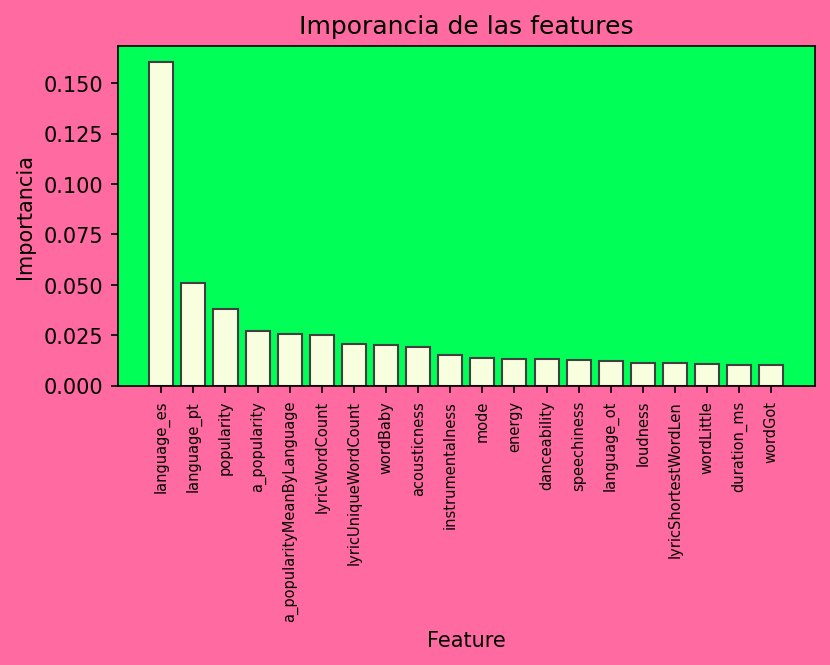

In [ ]:
#@title Importancias modelo xgb
ftImportances = pd.DataFrame(xgbModel.feature_importances_, index=xgbModel.get_booster().feature_names)\
                .rename(columns={0:"imp"}).sort_values("imp", ascending=False).head(20)

plt.figure(dpi=150, figsize=(6,3), facecolor="#FF6BA1")

X_axis = np.arange(len(ftImportances))

plt.bar(X_axis, ftImportances.imp, 0.75, color="#F8FFDE", edgecolor="#404040")

plt.axes().set_facecolor("#00FF57")
plt.xlabel("Feature")
plt.ylabel("Importancia")
plt.title("Imporancia de las features")
plt.xticks(X_axis, ftImportances.index, rotation=90, size=7)
plt.show()

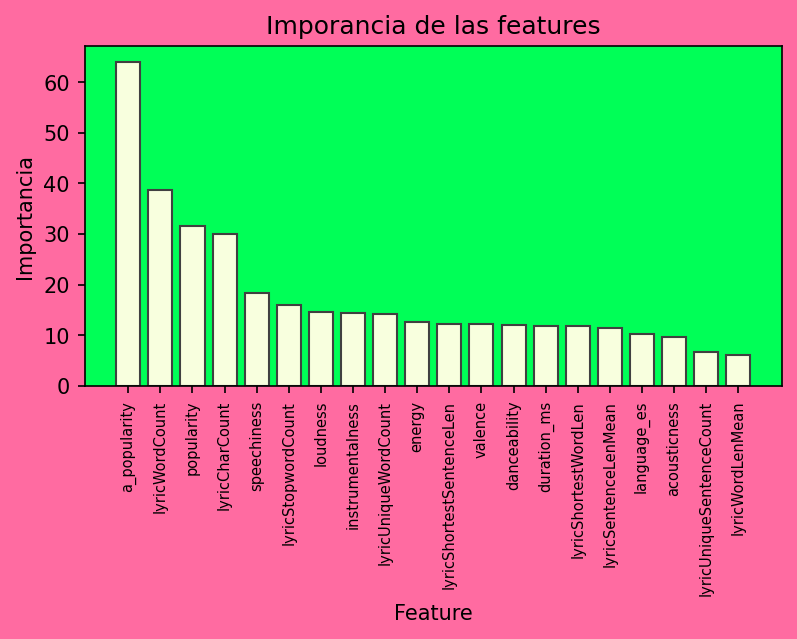

In [ ]:
#@title Importancias baseline logreg
from IPython.display import Image
Image('/content/drive/MyDrive/tp3/parte2/baseline-importances.png')